In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import pymc3 as pm
import numpy as np
import theano.tensor as tt

First, we need to set up our test data. We'll use two relaxation modes that are themselves log-normally distributed.

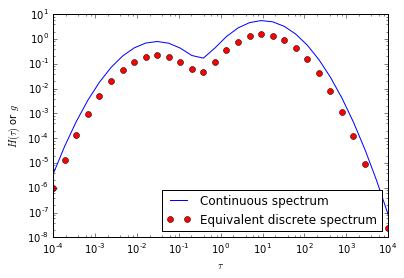

In [59]:
def H(tau):
    h1 = 1; tau1 = 0.03; sd1 = 0.5;
    h2 = 7; tau2 = 10; sd2 = 0.5;
    term1 = h1/np.sqrt(2*sd1**2*np.pi) * np.exp(-(np.log10(tau/tau1)**2)/(2*sd1**2))
    term2 = h2/np.sqrt(2*sd2**2*np.pi) * np.exp(-(np.log10(tau/tau2)**2)/(2*sd2**2))
    return term1 + term2

Nfreq = 50
Nmodes = 30
w = np.logspace(-4,4,Nfreq).reshape((1,Nfreq))
tau = np.logspace(-np.log10(w.max()),-np.log10(w.min()),Nmodes).reshape((Nmodes,1))

# get equivalent discrete spectrum
delta_log_tau = np.log10(tau[1]/tau[0])
g_true = (H(tau) * delta_log_tau).reshape((1,Nmodes))

plt.loglog(tau,H(tau), label='Continuous spectrum')
plt.plot(tau.ravel(),g_true.ravel(), 'or', label='Equivalent discrete spectrum')
plt.legend(loc=4)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$H(\tau)$ or $g$')
plt.savefig('Original_relax_spec.png',dpi=500)

Now, let's calculate the moduli. We'll have both a true version and a noisy version with some random noise added to simulate experimental variance.

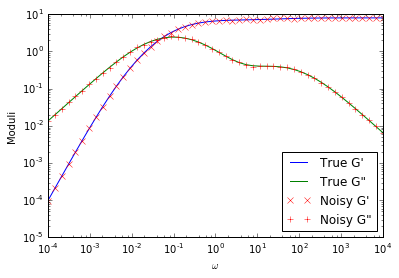

In [58]:
wt = tau*w
Kp = wt**2/(1+wt**2)
Kpp = wt/(1+wt**2)
noise_level = 0.02
Gp_true = np.dot(g_true,Kp)
Gp_noise = Gp_true + Gp_true*noise_level*np.random.randn(Nfreq)
Gpp_true = np.dot(g_true,Kpp)
Gpp_noise = Gpp_true + Gpp_true*noise_level*np.random.randn(Nfreq)
plt.loglog(w.ravel(),Gp_true.ravel(),label="True G'")
plt.plot(w.ravel(),Gpp_true.ravel(), label='True G"')
plt.plot(w.ravel(),Gp_noise.ravel(),'xr',label="Noisy G'")
plt.plot(w.ravel(),Gpp_noise.ravel(),'+r',label='Noisy G"')
plt.xlabel(r'$\omega$')
plt.ylabel("Moduli")
plt.legend(loc=4)
plt.savefig('Original_Moduli_spec.png',dpi=500)

Now, we can build the model with PyMC3. I'll make 2: one with noise, and one without.

In [4]:
noisyModel = pm.Model()
with noisyModel:
    g = pm.Lognormal('g', mu=0, tau=0.1, shape=g_true.shape)
    sd1 = pm.HalfNormal('sd1',tau=1)
    sd2 = pm.HalfNormal('sd2',tau=1)
    # we'll log-weight the moduli as in other fitting methods
    logGp = pm.Normal('logGp',mu=np.log(tt.dot(g,Kp)),  
                      sd=sd1, observed=np.log(Gp_noise))
    logGpp = pm.Normal('logGpp',mu=np.log(tt.dot(g,Kpp)), 
                      sd=sd2, observed=np.log(Gpp_noise))

trueModel = pm.Model()
with trueModel:
    g = pm.Lognormal('g', mu=0, tau=0.1, shape=g_true.shape)
    sd1 = pm.HalfNormal('sd1',tau=1)
    sd2 = pm.HalfNormal('sd2',tau=1)
    # we'll log-weight the moduli as in other fitting methods
    logGp = pm.Normal('logGp',mu=np.log(tt.dot(g,Kp)),  
                      sd=sd1, observed=np.log(Gp_true))
    logGpp = pm.Normal('logGpp',mu=np.log(tt.dot(g,Kpp)), 
                      sd=sd2, observed=np.log(Gpp_true))    

Applied log-transform to g and added transformed g_log_ to model.
Applied log-transform to sd1 and added transformed sd1_log_ to model.
Applied log-transform to sd2 and added transformed sd2_log_ to model.
Applied log-transform to g and added transformed g_log_ to model.
Applied log-transform to sd1 and added transformed sd1_log_ to model.
Applied log-transform to sd2 and added transformed sd2_log_ to model.


Now we can sample the models to get our parameter distributions:

In [5]:
Nsamples = 2000
trueMapEstimate = pm.find_MAP(model=trueModel)
with trueModel:
    trueTrace = pm.sample(Nsamples, start=trueMapEstimate)
pm.backends.text.dump('./Double_Maxwell_v3_true', trueTrace)

Assigned NUTS to g_log_
Assigned NUTS to sd1_log_
Assigned NUTS to sd2_log_
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 sec

In [6]:
noisyMapEstimate = pm.find_MAP(model=noisyModel)
with noisyModel:
    noisyTrace = pm.sample(Nsamples, start=noisyMapEstimate)
pm.backends.text.dump('./Double_Maxwell_v3_noisy', noisyTrace)

Assigned NUTS to g_log_
Assigned NUTS to sd1_log_
Assigned NUTS to sd2_log_
 [-----------------100%-----------------] 2001 of 2000 complete in 1389.4 sec

In [7]:
burn = 500
trueQ = pm.quantiles(trueTrace[burn:])
noisyQ = pm.quantiles(noisyTrace[burn:])

Plotting the quantiles gives us a sense of the uncertainty in our estimation of $g_i$:
---

In [39]:
def plot_quantiles(Q,ax):
    ax.fill_between(tau.ravel(), y1=Q['g'][2.5], y2=Q['g'][97.5], color='c',
               alpha=0.25)
    ax.fill_between(tau.ravel(), y1=Q['g'][25], y2=Q['g'][75], color='c',
               alpha=0.5)
    ax.plot(tau.ravel(), Q['g'][50], 'b-')
    # sampling localization lines:
    ax.axvline(x=np.exp(np.pi/2)/w.max(), color='k', linestyle='--')
    ax.axvline(x=(np.exp(np.pi/2)*w.min())**-1, color='k', linestyle='--')

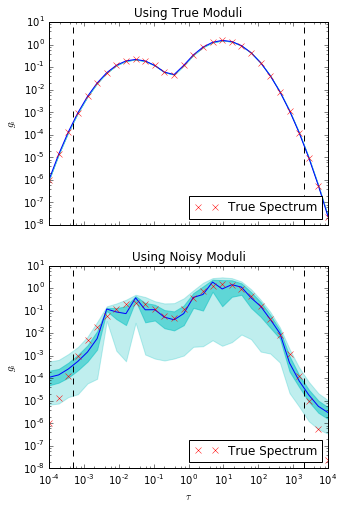

In [56]:
fig,ax = plt.subplots(nrows=2, sharex=True, 
                      subplot_kw={'xscale':'log','yscale':'log', 
                                  'ylabel':'$g_i$'})
plot_quantiles(trueQ,ax[0])
plot_quantiles(noisyQ,ax[1])
# true spectrum
trueSpectrumline0 = ax[0].plot(tau.ravel(), g_true.ravel(),'xr', 
                           label='True Spectrum')
trueSpectrumline1 = ax[1].plot(tau.ravel(), g_true.ravel(),'xr', 
                           label='True Spectrum')


ax[0].legend(loc=4)
ax[0].set_title('Using True Moduli')


ax[1].set_xlabel(r'$\tau$')
ax[1].legend(loc=4)
ax[1].set_title('Using Noisy Moduli')

fig.set_size_inches(5,8)
fig.savefig('True,Noisy_moduli.png',dpi=500)

In [40]:
noisySample = pm.sample_ppc(noisyTrace[burn:],model=noisyModel,samples=250)

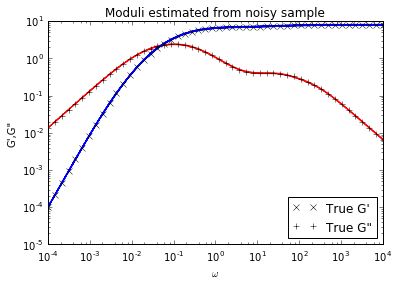

In [53]:
fig,ax = plt.subplots()
for logg1,logg2 in zip(noisySample['logGp'].reshape(250,50),
                 noisySample['logGpp'].reshape(250,50)):
    ax.plot(w.ravel(),np.exp(logg1),'b-',alpha=0.05)
    ax.plot(w.ravel(),np.exp(logg2),'r-',alpha=0.01)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\omega$')
ax.set_ylabel('G\',G"')
ax.plot(w.ravel(), Gp_true.ravel(),'xk', label='True G\'' )
ax.plot(w.ravel(), Gpp_true.ravel(), '+k', label='True G"')
ax.set_title('Moduli estimated from noisy sample')
plt.legend(loc=4)
plt.savefig('Re-estimated_moduli.png',dpi=500)